In [1]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm, trange

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance
/Users/mh522/firedrake/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
mesh  = UnitSquareMesh(1,1)
x,y = SpatialCoordinate(mesh)
print('x ', x)
print('y ', y)

x  x[0]
y  x[1]


In [2]:
def forward_model(E, nu, strain_tensor):
    # Mesh refinement parameters
    nx, ny = 5, 1
    mesh = RectangleMesh(nx, ny, 1, 1)
    x, y = SpatialCoordinate(mesh)
    V = VectorFunctionSpace(mesh, 'CG', 1)
    # Test and trial function for the displacement field
    v, u_ = TestFunction(V), TrialFunction(V)
    u = Function(V, name="Displacement")

    # Lamé parameter
    lmbda = E*nu/(1+nu)/(1-2*nu)
    mu = E/2/(1+nu)
    # Constitutive equations
    def eps(v):
        return 0.5*(grad(v) + grad(v).T)
    def sigma(v):
        d = 2
        return lmbda*tr(eps(v))*Identity(d) + 2*mu*eps(v)
    # Body force
    f = Constant((0.0, 0.0))
    
    # Convert strain tensor into displacement boundary conditions
    
    exx, eyy, exy = strain_tensor.dat.data[0,0,0], strain_tensor.dat.data[0,1,1], strain_tensor.dat.data[0,0,1]
    uLx = - exx/2 + exy * (y-.5)
    uLy = eyy * (y-.5) - exy/2
    uRx = exx/2 + exy * (y-.5)
    uRy = eyy * (y-.5) + exy/2
    
    uBx = exx * (x-.5) - exy/2
    uBy = - eyy/2 + exy * (x-.5)
    uTx = exx * (x-.5) + exy/2
    uTy = eyy/2 + exy * (x-.5)

    # Boundary conditions
    bcL = DirichletBC(V, [uLx, uLy], 1)
    bcR = DirichletBC(V, [uRx, uRy], 2)
    bcB = DirichletBC(V, [uBx, uBy], 3)
    bcT = DirichletBC(V, [uTx, uTy], 4)

    # Formal equation is div(sigma(u)) = f
    # Form
    a = inner(sigma(u_), eps(v)) * dx    
    L = inner(f, v) * dx
    # Solve PDE
    solve(a == L, u, bcs=[bcL, bcB, bcR, bcT], solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})

    # Boundary stress
    sxx = assemble(.5*sigma(u)[0, 0] * ds(1) + .5*sigma(u)[0, 0] * ds(2))
    syy = assemble(.5*sigma(u)[1, 1] * ds(3) + .5*sigma(u)[1, 1] * ds(4))
    sxy_syx = assemble(.25*sigma(u)[0, 1] * ds(1) +
                       .25*sigma(u)[0, 1] * ds(2) +
                       .25*sigma(u)[1, 0] * ds(3) +
                       .25*sigma(u)[1, 0] * ds(4))
    # Enforce symmetry: Sxy = Syx
    stress_tensor = np.array([[sxx, sxy_syx],
                              [sxy_syx, syy]])
    stress_tensor = as_tensor(stress_tensor)
    return project(stress_tensor, V_tensor)


In [3]:
# check 
def check_forward(E,nu,strain_tensor):
    lmbda = E*nu/(1+nu)/(1-2*nu)
    mu = E/2/(1+nu)
    # lmbda*tr(eps(v))*Identity(d) + 2*mu*eps(v), 0.1 is the trace of eps(v)
    s = lmbda*np.trace(strain_tensor)*np.eye(2) + 2*mu*strain_tensor
    return s


In [4]:

E = 30e3
nu = 0.3
strain_tensor = np.array([[0.01, 1],[1, 0.01]])
strain_fire = Constant([[0.01, 1], [1, 0.01]])
mesh = UnitSquareMesh(1,1)
V_tensor = TensorFunctionSpace(mesh, "CG", 1)
strain_fire = project(strain_fire, V_tensor)

stress_tensor = forward_model(E, nu, strain_fire)
stress_true = check_forward(E, nu, strain_tensor)


In [5]:
print('stress_tensor', stress_tensor.dat.data[0])
print('strain_tensor', strain_tensor)
print("stress_true",stress_true)

stress_tensor [[  576.92307692 23076.92307692]
 [23076.92307692   576.92307692]]
strain_tensor [[0.01 1.  ]
 [1.   0.01]]
stress_true [[  576.92307692 23076.92307692]
 [23076.92307692   576.92307692]]


In [6]:
## fire version
def get_dataset(ntrain, ntest):
    X, y = [], []

    for i in tqdm(range(ntrain + ntest)):
        # Randomly generate E and nu within given ranges
        E = np.random.uniform(30e3, 90e3)  # Young's modulus in Pa
        nu = np.random.uniform(0.1, 0.3)      # Poisson's ratio

        # Generate diagonal elements
        a11, a12, a22 = [np.random.uniform(-0.1, 0.1) for _ in range(3)]
        # Construct the 2x2 matrix
        strain = np.array([[a11, a12], [a12, a22]])
        
        # strain = project(as_tensor(strain), V_tensor)
        # stress = forward_model(E, nu, strain)
        stress = check_forward(E, nu, strain)
        
        
        
        # Flatten and concatenate [E, nu] and strain
        input_data = np.hstack([E, nu, a11, a22, a12])
        
        X.append(input_data)
        y.append([stress[0,0], stress[1,1], stress[0,1]])
        # y.append([stress.dat.data[0,0,0], stress.dat.data[0,1,1], stress.dat.data[0,0,1]])
    # print(y)
    # Convert lists to numpy arrays
    X_train, X_test = np.array(X[:ntrain]), np.array(X[ntrain:])
    y_train, y_test = np.array(y[:ntrain]), np.array(y[ntrain:])
    
    np.save("data/datasets/linear_elasticity/X_train.npy", X_train)
    np.save("data/datasets/linear_elasticity/y_train.npy", y_train)
    np.save("data/datasets/linear_elasticity/X_test.npy", X_test)
    np.save("data/datasets/linear_elasticity/y_test.npy", y_test)

In [7]:
ntrain = 2000
ntest = 200
get_dataset(ntrain, ntest)

100%|██████████| 2200/2200 [00:00<00:00, 57048.07it/s]


# train

In [8]:
# Loading
X_train = np.load("data/datasets/linear_elasticity/X_train.npy", allow_pickle=True)
X_test = np.load("data/datasets/linear_elasticity/X_test.npy", allow_pickle=True)
y_train = np.load("data/datasets/linear_elasticity/y_train.npy", allow_pickle=True)
y_test = np.load("data/datasets/linear_elasticity/y_test.npy", allow_pickle=True)

In [9]:
# Print some of the data
num_samples_to_display = 1

for i in range(num_samples_to_display):
    E, nu, a11, a22, a12 = X_train[i]
    stress_xx,stress_yy, stress_xy = y_train[i][0], y_train[i][1], y_train[i][2]
    stress = np.array([[stress_xx, stress_xy], [stress_xy, stress_yy]])
    print(f"Sample {i+1}:")
    print("-----------")
    print(f"E: {E:.2e}")
    print(f"nu: {nu:.2f}")
    print(f"Strain:\n[[{a11:.3f}, {a12:.3f}]\n [{a12:.3f}, {a22:.3f}]]")
    print(f"Stress:\n{stress}")
    print()

Sample 1:
-----------
E: 6.05e+04
nu: 0.13
Strain:
[[0.022, 0.004]
 [0.004, -0.067]]
Stress:
[[  718.59611453   189.52089968]
 [  189.52089968 -4019.38164252]]



In [10]:
import torch
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
print('X_train',X_train)
print('y_train', y_train)
# Compute the mean and standard deviation for the training data
X_mean = torch.mean(X_train_tensor, dim=0)
#X_min = torch.min(X_train_tensor, dim=1)
#X_max = torch.max(X_train_tensor, dim=1)
X_std = torch.std(X_train_tensor, dim=0)
y_mean = torch.mean(y_train_tensor, dim=0)
#y_min = torch.min(y_train_tensor, dim=1)
#y_max = torch.max(y_train_tensor, dim=1)
y_std = torch.std(y_train_tensor, dim=0)


# Standardize the training data
X_train_standardized = (X_train_tensor - X_mean) / X_std
y_train_standardized = (y_train_tensor - y_mean) / y_std

# Standardize the test data using the training data's statistics
X_test_standardized = (X_test_tensor - X_mean) / X_std
y_test_standardized = (y_test_tensor - y_mean) / y_std
print('mean and std ', y_mean, y_std)
print('\n')
print('X_train', X_train_standardized)
print('y_train', y_train_standardized)

print('\n')
print('X_train_back', X_train_standardized * X_std + X_mean)
print('y_train_back', y_train_standardized * y_std + y_mean)
# Normalization the training data
# X_train_standardized = (X_train_tensor - X_min) / (X_max - X_min)
# y_train_standardized = (y_train_tensor - y_min) / (y_max - y_min)

# # Normalization the test data using the training data's statistics
# X_test_standardized = (X_test_tensor - X_min) / (X_max - X_min)
# y_test_standardized = (y_test_tensor - y_min) / (X_max - X_min)

X_train [[ 6.04561416e+04  1.33034846e-01  2.16972518e-02 -6.70992502e-02
   3.55189362e-03]
 [ 4.66396663e+04  1.49245400e-01 -6.01297324e-03 -7.68354475e-02
   2.67019727e-02]
 [ 3.03300800e+04  1.28318350e-01 -9.85703590e-02 -9.63164374e-02
  -4.29759560e-02]
 ...
 [ 8.25477313e+04  2.10238417e-01 -8.60647117e-03 -1.64085091e-02
   9.84859703e-03]
 [ 8.09603002e+04  2.92232576e-01  2.05228250e-02  5.54513385e-02
   4.34014923e-02]
 [ 7.95657544e+04  1.32297696e-01  9.68749091e-02  7.60638505e-02
   9.22668133e-02]]
y_train [[  718.59611453 -4019.38164252   189.52089968]
 [ -959.3339577  -3833.51258484  1083.64244555]
 [-3553.94720411 -3493.360026   -1155.22731918]
 ...
 [-1206.00730771 -1738.1673528    671.75139197]
 [ 4633.26975689  6821.59328059  2719.16829327]
 [ 8993.50053629  7531.12224284  6483.52339524]]
mean and std  tensor([ 75.9950, 107.2874,  37.2291]) tensor([4220.1079, 4260.6670, 3028.6245])


X_train tensor([[ 0.0531, -1.1632,  0.3585, -1.1826,  0.0580],
        [-0.73

In [11]:
import torch.nn as nn
class MLP_model(nn.Module):
    def __init__(self):
        super(MLP_model, self).__init__()
        
        # Define your model architecture
        self.fc1 = nn.Linear(5, 8)  # Input size is 6
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 32)
        self.fc4 = nn.Linear(32, 3)  # Output size is 4

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        return x


In [12]:
from sklearn.model_selection import KFold
import numpy as np
import torch.optim as optim
import os

WEIGHT_DECAY = 0.01  # Regularization strength

def train_cross_validation(model, dataset, k_folds, epochs, batch_size, lr, criterion, device,save_folder):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    train_losses = []
    val_losses = []
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold+1}/{k_folds}")
        
        # Define data subsets for training and validation
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)
        
        # Re-initialize model for each fold
        model_fold = model()
        model_fold.to(device)
        optimizer_fold = optim.Adam(model_fold.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
        
        # Training loop for each fold
        for epoch in tqdm(range(epochs)):
            model_fold.train()
            current_train_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer_fold.zero_grad()
                outputs = model_fold(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer_fold.step()
                current_train_loss += loss.item()
                
            current_val_loss = 0.0
            model_fold.eval()
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model_fold(inputs)
                    loss = criterion(outputs, targets)
                    current_val_loss += loss.item()
            
            train_losses.append(current_train_loss/len(train_loader))
            val_losses.append(current_val_loss/len(val_loader))
            
            if epoch == epochs - 1:
                print(f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
            # Save model if the validation loss has decreased
            best_val_loss = np.Inf
            if current_val_loss < best_val_loss:
                best_val_loss = current_val_loss
                torch.save(model_fold.state_dict(), os.path.join(save_folder, f'best_model.pt'))
    # Plotting after all folds
    plt.figure(figsize=(12,4))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Fold 1/3


100%|██████████| 500/500 [00:27<00:00, 18.08it/s]


Train Loss: 0.0179, Val Loss: 0.0196
Fold 2/3


100%|██████████| 500/500 [00:27<00:00, 18.32it/s]


Train Loss: 0.0178, Val Loss: 0.0180
Fold 3/3


100%|██████████| 500/500 [00:27<00:00, 18.32it/s]


Train Loss: 0.0180, Val Loss: 0.0188


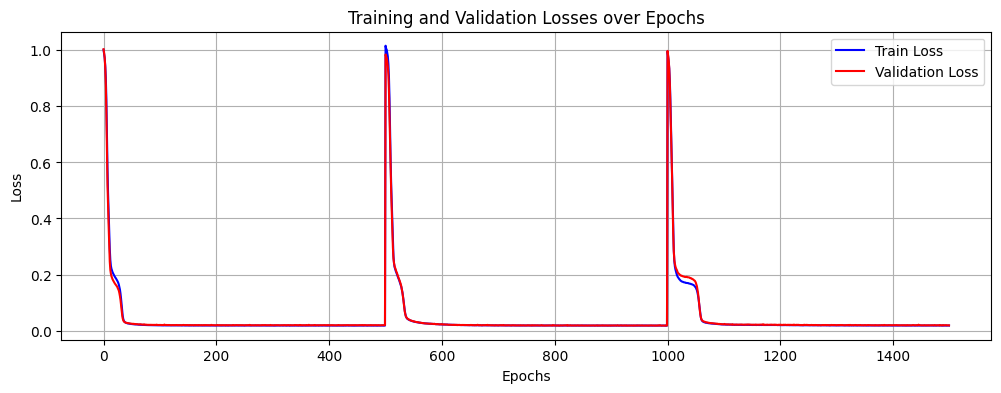

In [13]:
import torch
import torch.optim as optim

# Initialize the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model, criterion and optimizer
model = MLP_model().to(device)
criterion = nn.MSELoss()
# Hyperparameters
EPOCHS = 500
LEARNING_RATE = 0.0003
BATCH_SIZE = 16
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Dataset loading utilities
train_dataset = torch.utils.data.TensorDataset(X_train_standardized, y_train_standardized)
test_dataset = torch.utils.data.TensorDataset(X_test_standardized, y_test_standardized)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
save_folder = 'saved_models'
# Using the function:
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
train_cross_validation(MLP_model, combined_dataset, k_folds=3, epochs=EPOCHS,batch_size=BATCH_SIZE, lr=LEARNING_RATE, criterion=criterion, device=device, save_folder=save_folder)


# validation

In [14]:
# Load the trained model
model_path = "saved_models/best_model.pt"
model = MLP_model()  # assuming this is the correct name of the CNN model
model.load_state_dict(torch.load(model_path))
model.eval()

MLP_model(
  (fc1): Linear(in_features=5, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
)

In [15]:
strain_tensor = np.array([[0.1,0],[0, 0.1]])
E = 45e3
nu = 0.25

pred_input = torch.tensor([E, nu, strain_tensor[0,0], strain_tensor[1,1], strain_tensor[0,1]], dtype=torch.float32)
stress_pred = model.predict(pred_input)
# convert to engineering stress
stress_pred = (stress_pred * y_std) + y_mean
# convert to numpy array
stress_pred = stress_pred.detach().numpy()
stress_pred = np.array([[stress_pred[0], stress_pred[2]],[stress_pred[2], stress_pred[1]]])

strain_fire = as_tensor(strain_tensor)
strain_fire = project(strain_fire, V_tensor)
# generate true stress
stress_ground_true = check_forward(E, nu, strain_tensor)
stress_true = forward_model(E, nu, strain_fire)


In [16]:
print('stress prediction:', stress_pred)
print('stress true', stress_true.dat.data[0])
print('stress ground', stress_ground_true)

stress prediction: [[ 222.15234   -35.491623]
 [ -35.491623 -120.15223 ]]
stress true [[ 7.20000000e+03 -1.18655086e-15]
 [-1.18655086e-15  7.20000000e+03]]
stress ground [[7200.    0.]
 [   0. 7200.]]


# add physics driven

In [18]:
import os
# import parser
import torch.optim as optim
import torch.autograd as torch_ad

from sklearn.model_selection import KFold

from tqdm.auto import tqdm, trange
from torch.utils.data import DataLoader

from firedrake import *
from firedrake_adjoint import *
from firedrake.ml.pytorch import torch_operator

from physics_driven_ml.dataset_processing import PDEDataset, BatchedElement
from physics_driven_ml.models import EncoderDecoder, CNN
from physics_driven_ml.utils import ModelConfig, get_logger
from physics_driven_ml.evaluation import evaluate


In [56]:

def train(model, config: ModelConfig,
        dataset,
        G: torch_ad.Function, H: torch_ad.Function):
    """Train the model on a given dataset."""
    optimiser = optim.AdamW(model.parameters(), lr=config.learning_rate, eps=1e-8)
    criterion = nn.MSELoss()
    
    max_grad_norm = 1.0
    best_error = 0.
    kfold = KFold(n_splits=config.K_fold, shuffle=True)
    train_losses = []
    val_losses = []
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold+1}/{config.K_fold}")
        
        # Define data subsets for training and validation
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, sampler=val_subsampler)
        
        # Re-initialize model for each fold
        # model = model()
        model.to(config.device)
        optimizer_fold = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.WEIGHT_DECAY)
        
        # training loop
        loss_phy_total = 0.0
        loss_ml_total = 0.0
        for epoch in tqdm(range(config.epochs)):
            model.train()
            current_train_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer_fold.zero_grad()
                outputs = model(inputs)
                
                # calculate physics loss
                loss_phi = G(inputs, outputs)
                loss_phy_total += loss_phi
                # calculate machine learning loss
                loss_ml = H(outputs, targets)
                loss_ml_total += loss_ml
                # back propagation
                loss = loss_phi + config.alpha * loss_ml
                loss.backward()
                
                optimizer_fold.step()
                current_train_loss += loss.item()
                
            # validation loop
            model.eval()
            current_val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    current_val_loss += loss.item()
            
            # print current losses
            train_losses.append(current_train_loss/len(train_loader))
            val_losses.append(current_val_loss/len(val_loader))
            if epoch == config.epochs - 1:
                print(f"Epoch {epoch+1}/{config.epochs} | Train Loss: {current_train_loss/len(train_loader)} | Validation Loss: {current_val_loss/len(val_loader)}")

            # Save best-performing model
            if current_val_loss < best_error or epoch == 0:
                best_error = current_val_loss
                torch.save(model.state_dict(), os.path.join(save_folder, f'best_model.pt'))
    # plot losses
    plt.figure(figsize=(12,4))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()    

    return model

### add physics driven here

In [57]:
import functools

def assemble_L2_error(x, x_exact):
    """Assemble L2-loss"""
    return assemble(0.5 * (x - x_exact) ** 2 * dx)

def solve_pde(strain, stress_obs, f, V,V_tensor):
    """Solve Poisson problem"""
    E = strain.dat.data[0]
    nu = strain.dat.data[1]
    mu = E/(2*(1+nu))
    lmbda = E*nu/((1+nu)*(1-2*nu))
    # return 0.5*(grad(u) + grad(u).T)
    exx, eyy, exy = strain.dat.data[2], strain.dat.data[3], strain.dat.data[4]
    uLx = - exx/2 + exy * (y-.5)
    uLy = eyy * (y-.5) - exy/2
    uRx = exx/2 + exy * (y-.5)
    uRy = eyy * (y-.5) + exy/2
    
    uBx = exx * (x-.5) - exy/2
    uBy = - eyy/2 + exy * (x-.5)
    uTx = exx * (x-.5) + exy/2
    uTy = eyy/2 + exy * (x-.5)

    # Boundary conditions
    bcL = DirichletBC(V, [uLx, uLy], 1)
    bcR = DirichletBC(V, [uRx, uRy], 2)
    bcB = DirichletBC(V, [uBx, uBy], 3)
    bcT = DirichletBC(V, [uTx, uTy], 4)
    
    def sigma(u):
        return 2*mu*sym(grad(u)) + lmbda*tr(sym(grad(u)))*Identity(2)

    def epsilon(u):
        return sym(grad(u))

    u = Function(V)
    v, u_ = TestFunction(V), TrialFunction(V)
    a = inner(sigma(u_), epsilon(v)) * dx    
    L = inner(f, v) * dx
    # Solve PDE (using LU factorisation)
    solve(a == L, u, bcs=[bcL, bcB, bcR, bcT], solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})
    # Boundary stress
    sxx = assemble(.5*sigma(u)[0, 0] * ds(1) + .5*sigma(u)[0, 0] * ds(2))
    syy = assemble(.5*sigma(u)[1, 1] * ds(3) + .5*sigma(u)[1, 1] * ds(4))
    sxy_syx = assemble(.25*sigma(u)[0, 1] * ds(1) +
                       .25*sigma(u)[0, 1] * ds(2) +
                       .25*sigma(u)[1, 0] * ds(3) +
                       .25*sigma(u)[1, 0] * ds(4))
    # Enforce symmetry: Sxy = Syx

    stress_tensor = np.array([[sxx, sxy_syx],
                              [sxy_syx, syy]])
    stress_tensor = as_tensor(stress_tensor)
    stress_tensor = project(stress_tensor, V_tensor)
    # Assemble Firedrake L2-loss (and not l2-loss as in PyTorch)
    return assemble_L2_error(stress_tensor, stress_obs)

x, y = SpatialCoordinate(mesh)
V = VectorFunctionSpace(mesh, "CG", 1)

f = Constant((0,0))

# mesh2 = RectangleMesh(3,1,1,1)
V1 = FunctionSpace(mesh, "CG", 1)
# V2 = FunctionSpace(mesh2, "CG", 1)
V_tensor = TensorFunctionSpace(mesh, "CG", 1)
V_vector = VectorFunctionSpace(mesh, "CG", 1)
solve_pde = functools.partial(solve_pde, f=f, V=V_vector, V_tensor=V_tensor)


# Construct the Firedrake torch operators
strain_ = Function(V1)
stress_ = Function(V1)
stress_obs = Function(V1)

# Set tape locally to only record the operations relevant to G on the computational graph
with set_working_tape() as tape:
    # Define PyTorch operator for solving the PDE and compute the L2 error (for computing κ -> 0.5 * ||u(κ) - u_obs||^{2}_{L2})
    F = ReducedFunctional(solve_pde(strain_, stress_obs), [Control(strain_), Control(stress_obs)])
    G = torch_operator(F)

# Set tape locally to only record the operations relevant to H on the computational graph
with set_working_tape() as tape:
    # Define PyTorch operator for computing the L2-loss (for computing κ -> 0.5 * ||κ - κ_exact||^{2}_{L2})
    F = ReducedFunctional(assemble_L2_error(stress, stress_obs), [Control(stress), Control(stress_obs)])
    H = torch_operator(F)


AttributeError: module 'firedrake.mesh' has no attribute 'ufl_domain'

In [ ]:
# args = parser.parse_args()
config = ModelConfig()
config.batch_size = 1
train_dataset = torch.utils.data.TensorDataset(X_train_standardized, y_train_standardized)
test_dataset = torch.utils.data.TensorDataset(X_test_standardized, y_test_standardized)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config.batch_size, shuffle=False)
save_folder = 'saved_models'

config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.save_folder = 'saved_models'
# Using the function:
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
train_model = MLP_model()
train(train_model, config, combined_dataset, G=G, H=H)


In [ ]:
# validation
# Load the trained model
model_path = "saved_models/best_model.pt"
model = MLP_model()  # assuming this is the correct name of the CNN model
model.load_state_dict(torch.load(model_path))
model.eval()
strain_tensor = np.array([[0.1,0],[0, 0.1]])
E = 45e3
nu = 0.25

pred_input = torch.tensor([E, nu, strain_tensor[0,0], strain_tensor[1,1], strain_tensor[0,1]], dtype=torch.float32)
stress_pred = model.predict(pred_input)
# convert to engineering stress
stress_pred = (stress_pred * y_std) + y_mean
# convert to numpy array
stress_pred = stress_pred.detach().numpy()
stress_pred = np.array([[stress_pred[0], stress_pred[2]],[stress_pred[2], stress_pred[1]]])


# generate true stress
stress_ground_true = check_forward(E, nu, strain_tensor)
stress_true = forward_model(E, nu, strain_tensor)

print('stress prediction:', stress_pred)
print('stress true', stress_true)
print('stress ground', stress_ground_true)